# Claude + E2B Code interpreter

**Powered by [Code Interpreter SDK](https://github.com/e2b-dev/code-interpreter) by [E2B](https://e2b.dev/docs)**

E2B's code interpreter SDK quickly creates a secure cloud sandbox powered by [Firecracker](https://github.com/firecracker-microvm/firecracker).
Inside this sandbox is a running Jupyter server that the LLM can use.

In [1]:
%pip install e2b_code_interpreter anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.1/869.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00


In [3]:
# TODO: Get your Anthropic API key from https://anthropic.com
ANTHROPIC_API_KEY = ""

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = ""


MODEL_NAME = "claude-3-opus-20240229"

SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.

## style guide
tool response values that have text inside "[]"  mean that a visual element got rended in the notebook. for example:
- "[chart]" means that a chart was generated in the notebook.
"""

tools = [
    {
        "name": "execute_python",
        "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
        "input_schema": {
            "type": "object",
            "properties": {
                "code": {
                    "type": "string",
                    "description": "The python code to execute in a single cell."
                }
            },
            "required": ["code"]
        }
    }
]

In [11]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [23]:
from anthropic import Anthropic
client = Anthropic(
    api_key=ANTHROPIC_API_KEY,
)

def process_tool_call(e2b_code_interpreter, tool_name, tool_input):
    if tool_name == "execute_python":
        return code_interpret(e2b_code_interpreter, tool_input["code"])
    return []

def chat_with_claude(e2b_code_interpreter, user_message):
    print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")

    message = client.beta.tools.messages.create(
        model=MODEL_NAME,
        system=SYSTEM_PROMPT,
        max_tokens=4096,
        messages=[{"role": "user", "content": user_message}],
        tools=tools,
    )

    print(f"\nInitial Response:")
    print(f"Stop Reason: {message.stop_reason}")
    print(f"Content: {message.content}")

    if message.stop_reason == "tool_use":
        tool_use = next(block for block in message.content if block.type == "tool_use")
        tool_name = tool_use.name
        tool_input = tool_use.input

        print(f"\nTool Used: {tool_name}")
        print(f"Tool Input: {tool_input}")

        code_interpreter_results = process_tool_call(e2b_code_interpreter, tool_name, tool_input)

        print(f"Tool Result: {code_interpreter_results}")
        return code_interpreter_results


User Message: Calculate value of pi using monte carlo method. Use 1000 iterations. Visualize all point of all iterations on a single plot, a point inside the unit circle should be green, other points should be gray.

Initial Response:
Stop Reason: tool_use
Content: [TextBlock(text='<thinking>\nTo calculate pi using Monte Carlo method and visualize the points, the relevant tool is `execute_python`. It requires a single parameter `code`, which is the python code to execute.\n\nThe problem provides all the necessary information to write the Python code:\n- Use Monte Carlo method\n- 1000 iterations\n- Visualize all points on a single plot\n- Points inside unit circle should be green, other points gray\n\nI have enough information to write the full Python code to solve this problem, so I will proceed with the tool invocation.\n</thinking>', type='text'), ToolUseBlock(id='toolu_01JUa8yPUAEY9mbdzLemVMTN', input={'code': "import numpy as np\nimport matplotlib.pyplot as plt\n\nn = 1000\nx = np

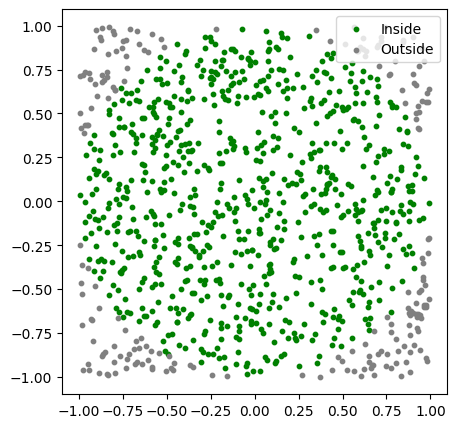

In [25]:
from e2b_code_interpreter import CodeInterpreter

with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
  code_interpreter_results = chat_with_claude(
    code_interpreter,
    "Calculate value of pi using monte carlo method. Use 1000 iterations. Visualize all point of all iterations on a single plot, a point inside the unit circle should be green, other points should be gray.",
  )
  result = code_interpreter_results[0]
  print(result)

# This will render the image
# You can also access the data directly
# result.png
# result.jpg
# result.pdf
# ...
result